In [2]:
#MacOS 兼容性操作
import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM

import altair as alt
from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model

import nbimporter

In [5]:
model = load_model('BTC_predict_test3.keras')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
import joblib

# 加载scaler
scaler = joblib.load('scaler.pkl')

In [17]:
data_30d = pd.read_csv('BTC_30D.csv')

# Display the first 5 rows
print(data_30d.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types
print(data_30d.info())

| timeOpen   | Close   | Open    | High    | Low     | volume   | Chg.(%)   |
|:-----------|:--------|:--------|:--------|:--------|:---------|:----------|
| 2024/5/19  | 66279.1 | 66919   | 67662.5 | 65937.3 | 36190    | -0.01     |
| 2024/5/20  | 71422.7 | 66278.3 | 71482.8 | 66076.5 | 112660   | 0.08      |
| 2024/5/21  | 70139.9 | 71430.5 | 71872   | 69181.7 | 108560   | -0.02     |
| 2024/5/22  | 69155.4 | 70141   | 70593.4 | 69024.3 | 65080    | -0.01     |
| 2024/5/23  | 67975.7 | 69166.3 | 70041   | 66578.1 | 89450    | -0.02     |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   timeOpen  30 non-null     object 
 1   Close     30 non-null     float64
 2   Open      30 non-null     float64
 3   High      30 non-null     float64
 4   Low       30 non-null     float64
 5   volume    30 non-null     float64
 6   Chg.(%)   30 non-null     float64
d

In [18]:
price_30d = data_30d.drop(['timeOpen', 'Chg.(%)'], axis=1)

scaled_30d_data = scaler.transform(price_30d)

print(scaled_30d_data.shape)
print(type(scaled_30d_data))

(30, 5)
<class 'numpy.ndarray'>


In [19]:
scaled_30d_data = scaled_30d_data.reshape(1, 30, 5)
print(scaled_30d_data.shape)
print(scaled_30d_data)

(1, 30, 5)
[[[9.81476290e-01 9.90956300e-01 9.80704775e-01 9.93997874e-01
   8.03803179e-06]
  [1.05777238e+00 9.81452777e-01 1.03620779e+00 9.96099222e-01
   2.51454153e-05]
  [1.03874434e+00 1.05787552e+00 1.04186226e+00 1.04297498e+00
   2.42281893e-05]
  [1.02414105e+00 1.03874833e+00 1.02328619e+00 1.04059888e+00
   1.45011194e-05]
  [1.00664231e+00 1.02429057e+00 1.01526068e+00 1.00367132e+00
   1.99530213e-05]
  [1.01512542e+00 1.00656213e+00 1.00321660e+00 1.00529715e+00
   1.40984348e-05]
  [1.02605453e+00 1.01512228e+00 1.00825506e+00 1.03292715e+00
   5.57270726e-06]
  [1.01463889e+00 1.02608389e+00 1.00731362e+00 1.02958190e+00
   5.44071620e-06]
  [1.02819496e+00 1.01462389e+00 1.02393852e+00 1.02929055e+00
   1.09194637e-05]
  [1.01243171e+00 1.02817683e+00 1.00828267e+00 1.01456753e+00
   1.59127526e-05]
  [1.00160050e+00 1.01242266e+00 9.98648855e-01 1.01220201e+00
   1.16040275e-05]
  [1.01226410e+00 1.00152187e+00 1.00746907e+00 1.01212955e+00
   1.48948555e-05]
  [1.

In [20]:
#定义函数
def predict_and_update(model, scaled_30d_data, num_predictions):
    """
    使用模型进行多次预测，并在每次预测后更新输入数据。

    参数:
        model: 训练好的预测模型。
        scaled_30d_data: 初始的归一化价格数据，形状为 (1, 30, 5)。
        num_predictions: 要进行的预测次数。

    返回:
        所有预测结果组成的列表。
    """
    predictions = []
    for _ in range(num_predictions):
        # 预测
        predict_30d = model.predict(scaled_30d_data)

        # 转换 predict_30d 的形状并拼接
        scaled_30d_data = np.concatenate([scaled_30d_data, predict_30d.reshape(1, 1, 5)], axis=1)

        # 删除第一个元素
        scaled_30d_data = scaled_30d_data[:, 1:]

        predictions.append(predict_30d)

    return predictions

In [21]:
a = predict_and_update(model, scaled_30d_data, 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━

In [22]:
a = np.array(a)
print(a.shape)
a_reshape = a.reshape(30, 5)
a_reshape_result = scaler.inverse_transform(a_reshape)
#print(a_reshape_result)
a_close_result = a_reshape_result[:, 0]
print(a_close_result)

(30, 1, 5)
[63787.41  61794.58  59984.63  58401.29  56997.914 55736.047 54595.535
 53566.477 52643.242 51821.137 51095.164 50459.477 49907.258 49431.438
 49024.73  48679.88  48389.586 48146.75  47944.625 47777.207 47638.227
 47518.062 47408.723 47305.05  47204.02  47104.074 47004.78  46906.17
 46808.305 46711.184]


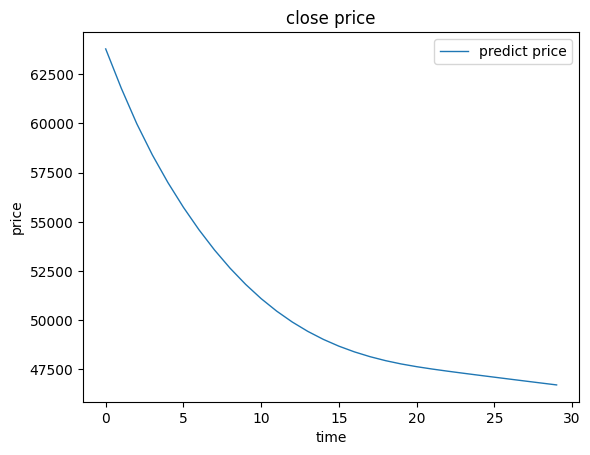

In [23]:
time_result = list(range(len(a_close_result)))

fig4 = plt.figure()
plt.plot(time_result, a_close_result, label='predict price',linewidth = 1)
plt.legend()
plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()